# Prepare Data files.
- Use returns instead.

In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

### prepare data directory.

In [12]:
from gw2ml.data.s3_sync import download_folder_from_s3
import pandas as pd
import os

workdir_raw = os.path.join(os.getenv('DATA_PATH'), 'workdir_lusis', 'raw')
workdir_modified = os.path.join(os.getenv('DATA_PATH'), 'workdir_lusis', 'modified')

os.makedirs(workdir_raw, exist_ok=True)
os.makedirs(workdir_modified, exist_ok=True)

download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1764510842', local_folder=os.path.join(workdir_raw, 'data'))

Source: ost-s3/datasources/gw2/raw/1764510842
Target: /models/data/workdir_lusis/raw

Found 280 files to download

✓ +1 Agony Infusion.csv
✓ Aetherkey Piece.csv
✓ Ancient Bone.csv
✓ Ancient Wood Log.csv
✓ Ancient Wood Plank.csv
✓ Antique Summoning Stone.csv
✓ Armored Scale.csv
✓ Asparagus Spear.csv
✓ Auric Sliver.csv
✓ Bag of Alchemical Materials.csv
✓ Bag of Coffee Beans.csv
✓ Bag of Flour.csv
✓ Bag of Starch.csv
✓ Bag of Stolen Goods.csv
✓ Bag of Sugar.csv
✓ Bay Leaf.csv
✓ Beet.csv
✓ Black Lion Chest.csv
✓ Black Peppercorn.csv
✓ Blackberry.csv
✓ Blueberry.csv
✓ Bolt of Cotton.csv
✓ Bolt of Gossamer.csv
✓ Bolt of Jute.csv
✓ Bolt of Silk.csv
✓ Bolt of Wool.csv
✓ Bone Chip.csv
✓ Bone Shard.csv
✓ Bottle of Soy Sauce.csv
✓ Bottle of Vintage Wine.csv
✓ Bowl of Candy Corn Custard.csv
✓ Bowl of Chocolate Frosting.csv
✓ Bowl of Coleslaw.csv
✓ Bowl of Fancy Bean Chili.csv
✓ Bronze Ingot.csv
✓ Candy Corn Cookie.csv
✓ Carrot.csv
✓ Cassava Root.csv
✓ Cayenne Pepper.csv
✓ Charged Shard.csv
✓ Chato

In [3]:
# Be a bit careful, this loads the entire directory into memory!
from tqdm import tqdm
data = []
csv_files = [f for f in os.path.join(workdir_raw, 'data') if f.endswith('.csv')]

for csv_file in tqdm(csv_files, desc="Loading CSV files"):
    file_path = os.path.join(workdir_raw, csv_file)
    df = pd.read_csv(file_path, delimiter=';')
    data.append(df)

print(f"\nTotal DataFrames loaded: {len(data)}")

# Set timestamp as index and drop fetched_at and created_at columns
for i in tqdm(range(len(data)), desc="Processing timestamps"):
    data[i] = data[i].drop(columns=['fetched_at', 'created_at', 'id', 'whitelisted'])
    data[i] = data[i].set_index('timestamp')

data[1].head()


Loading CSV files: 100%|██████████| 280/280 [00:07<00:00, 36.78it/s]



Total DataFrames loaded: 280


Processing timestamps: 100%|██████████| 280/280 [00:00<00:00, 1053.59it/s]


,item_id,buy_quantity,buy_unit_price,sell_quantity,sell_unit_price
timestamp,,,,,
2025-07-29 14:45:28.488814+00:00,102255,25448,186,89414,190
2025-07-29 14:50:27.564034+00:00,102255,25414,186,89640,190
2025-07-29 14:55:28.456291+00:00,102255,25387,186,89640,190
2025-07-29 15:00:37.541989+00:00,102255,25741,187,89499,190
2025-07-29 15:05:28.851131+00:00,102255,25739,187,89723,190


In [4]:
# Calculate simple returns for each DataFrame
for i in tqdm(range(len(data)), desc="Calculating simple returns"):
    # Save item_id column before calculating returns
    item_id_col = data[i]['item_id']

    # Calculate percentage change (simple returns) for all columns except item_id
    data[i] = data[i].drop(columns=['item_id']).pct_change()

    # Add item_id column back
    data[i]['item_id'] = item_id_col

    # Drop the first row which will be NaN after pct_change
    data[i] = data[i].dropna()

print(f"\nReturns calculated for {len(data)} DataFrames")
data[1].head()

Calculating simple returns: 100%|██████████| 280/280 [00:00<00:00, 551.80it/s]


Returns calculated for 280 DataFrames


,buy_quantity,buy_unit_price,sell_quantity,sell_unit_price,item_id
timestamp,,,,,
2025-07-29 14:50:27.564034+00:00,-0.001336,0.000000,0.002528,0.0,102255
2025-07-29 14:55:28.456291+00:00,-0.001062,0.000000,0.000000,0.0,102255
2025-07-29 15:00:37.541989+00:00,0.013944,0.005376,-0.001573,0.0,102255
2025-07-29 15:05:28.851131+00:00,-0.000078,0.000000,0.002503,0.0,102255
2025-07-29 15:10:30.104458+00:00,-0.006527,0.000000,-0.001148,0.0,102255


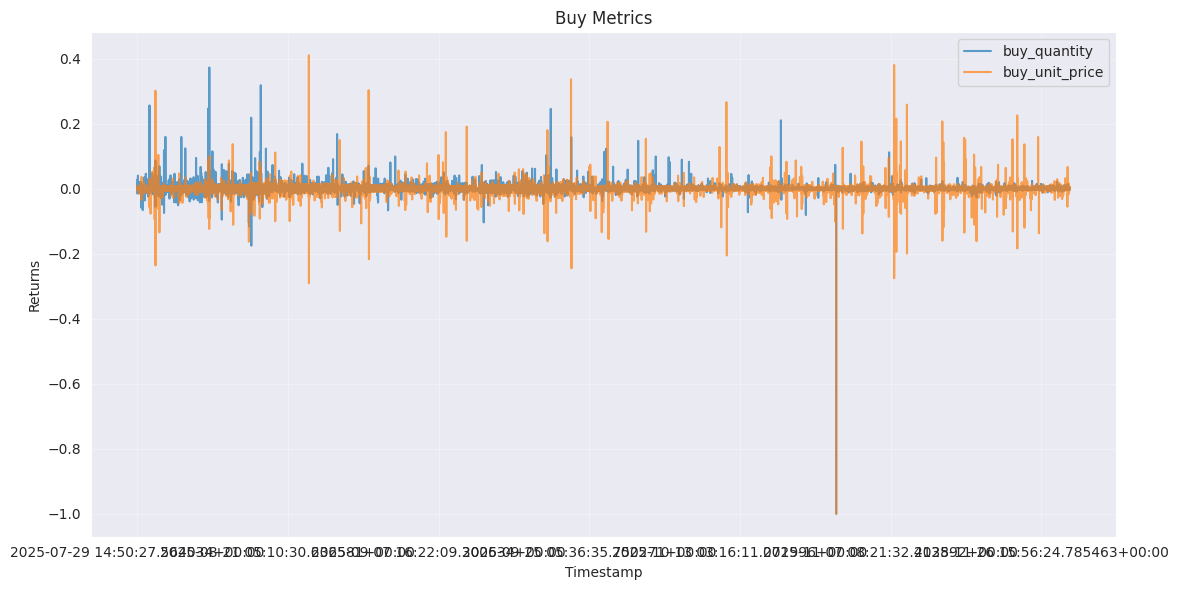

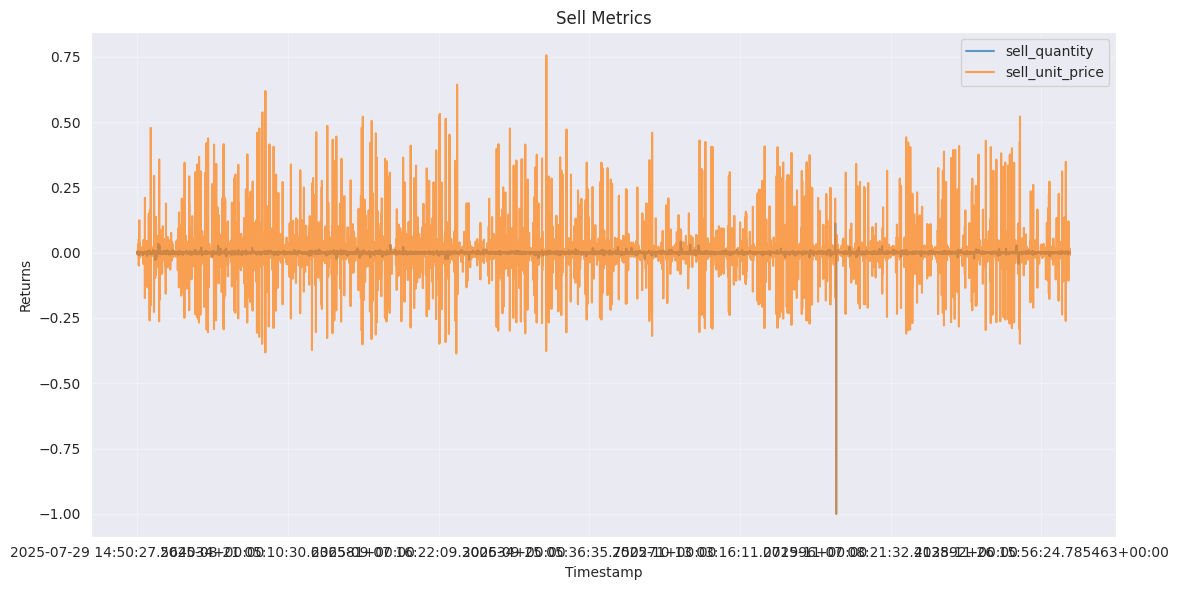

In [10]:

import matplotlib.pyplot as plt
# Matplotlib is faster than seaborn for simple line plots
df_to_plot = data[1].drop(columns=['item_id'])

# Plot buy columns together
buy_cols = [col for col in df_to_plot.columns if col.startswith('buy_')]
if buy_cols:
    plt.figure(figsize=(12, 6))
    df_to_plot[buy_cols].plot(alpha=0.7, ax=plt.gca())
    plt.title('Buy Metrics')
    plt.xlabel('Timestamp')
    plt.ylabel('Returns')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot sell columns together
sell_cols = [col for col in df_to_plot.columns if col.startswith('sell_')]
if sell_cols:
    plt.figure(figsize=(12, 6))
    df_to_plot[sell_cols].plot(alpha=0.7, ax=plt.gca())
    plt.title('Sell Metrics')
    plt.xlabel('Timestamp')
    plt.ylabel('Returns')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run Dickey fuller on the augmented data set.

In [11]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

def adf_test(series, name=''):
     # Replace inf with NaN and drop all NaN values
    clean_series = series.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_series) < 12:  # ADF test needs sufficient observations
        return {
            'Series': name,
            'ADF Statistic': np.nan,
            'p-value': np.nan,
            'Lags Used': np.nan,
            'Observations': len(clean_series),
            'Critical Value (1%)': np.nan,
            'Critical Value (5%)': np.nan,
            'Critical Value (10%)': np.nan,
            'Stationary (5%)': 'Insufficient Data'
        }

    result = adfuller(clean_series, autolag='AIC')
    return {
        'Series': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%'],
        'Stationary (5%)': 'Yes' if result[1] < 0.05 else 'No'
    }


# Run ADF test for all items
adf_results = []

for idx, df in enumerate(tqdm(data, desc="Running ADF tests")):
    item_id = df['item_id'].iloc[0] if 'item_id' in df.columns else idx

    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        if col != 'item_id':
            result = adf_test(df[col], name=f"Item {item_id} - {col}")
            adf_results.append(result)

# Convert results to DataFrame for easier viewing
adf_df = pd.DataFrame(adf_results)

Running ADF tests: 100%|██████████| 280/280 [19:59<00:00,  4.28s/it]


In [ ]:
# Save modified files


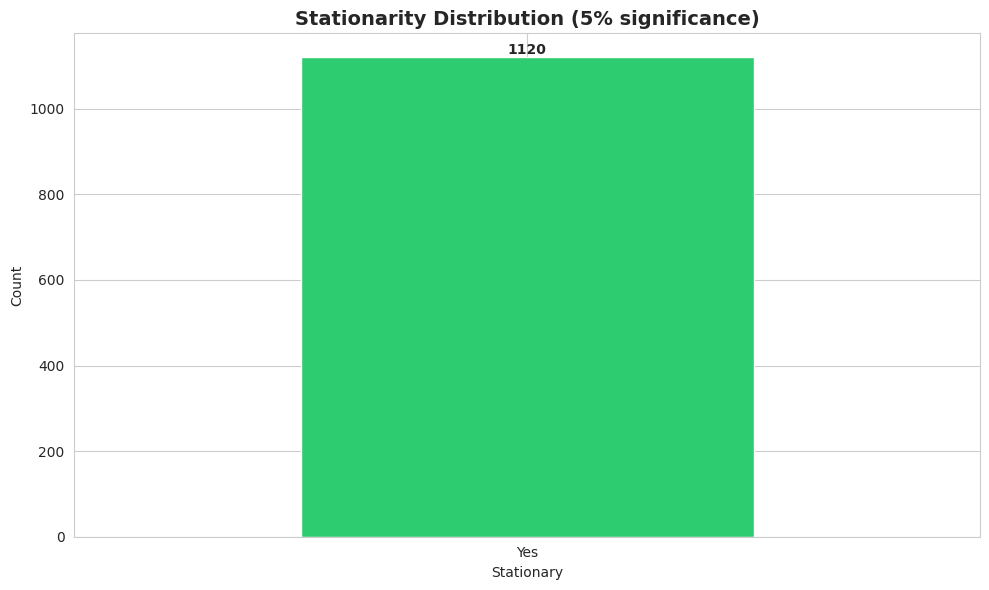

In [13]:
# Visualize ADF test results
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))

stationary_counts = adf_df['Stationary (5%)'].value_counts()
colors = ['#2ecc71' if x == 'Yes' else '#e74c3c' for x in stationary_counts.index]
stationary_counts.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Stationarity Distribution (5% significance)', fontsize=14, fontweight='bold')
ax.set_xlabel('Stationary')
ax.set_ylabel('Count')
ax.tick_params(rotation=0)
for i, v in enumerate(stationary_counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(workdir_modified,"adf_results", 'adf_stationarity_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

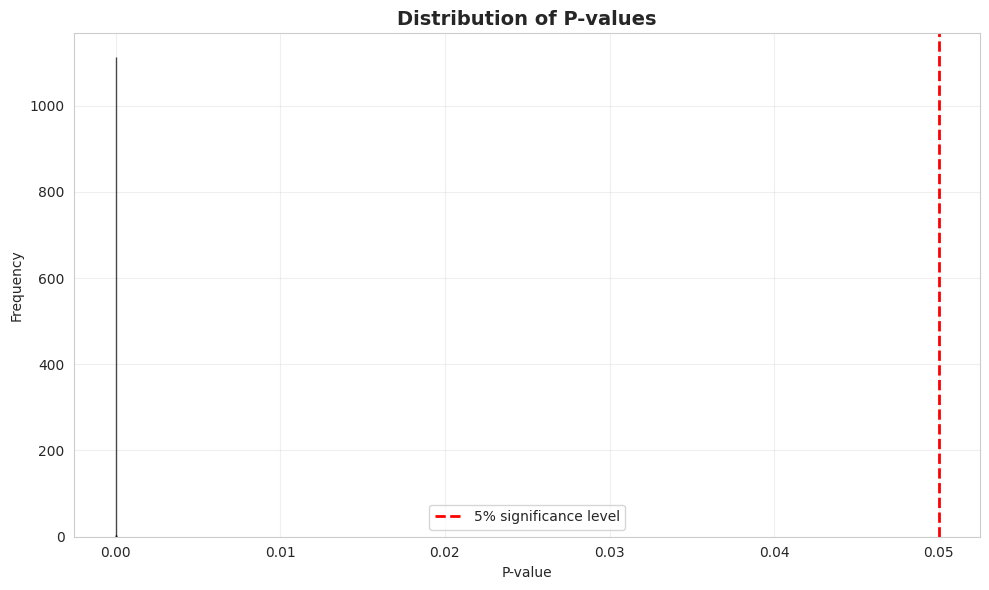

In [14]:
# 2. P-value distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(adf_df['p-value'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='5% significance level')
ax.set_title('Distribution of P-values', fontsize=14, fontweight='bold')
ax.set_xlabel('P-value')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(workdir_modified,"adf_results", 'adf_pvalue_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

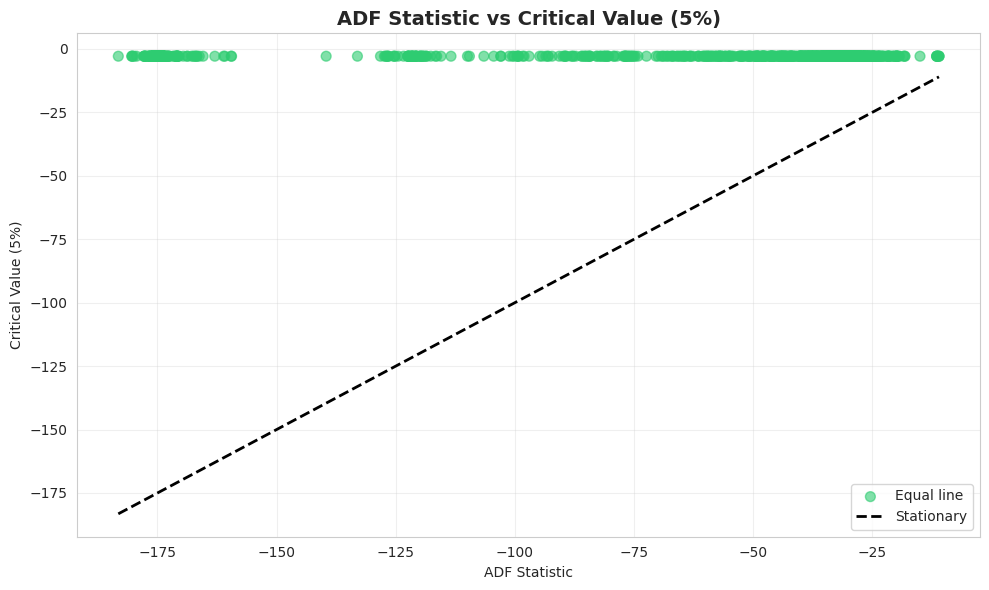

In [15]:
# 3. ADF Statistic vs Critical Value (5%)
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(adf_df['ADF Statistic'], adf_df['Critical Value (5%)'],
           c=adf_df['Stationary (5%)'].map({'Yes': '#2ecc71', 'No': '#e74c3c'}),
           alpha=0.6, s=50)
ax.plot([adf_df['ADF Statistic'].min(), adf_df['ADF Statistic'].max()],
         [adf_df['ADF Statistic'].min(), adf_df['ADF Statistic'].max()],
         'k--', linewidth=2, label='Equal line')
ax.set_title('ADF Statistic vs Critical Value (5%)', fontsize=14, fontweight='bold')
ax.set_xlabel('ADF Statistic')
ax.set_ylabel('Critical Value (5%)')
ax.legend(['Equal line', 'Stationary', 'Non-stationary'])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(workdir_modified,"adf_results", 'adf_statistic_vs_critical.png'), dpi=300, bbox_inches='tight')
plt.show()

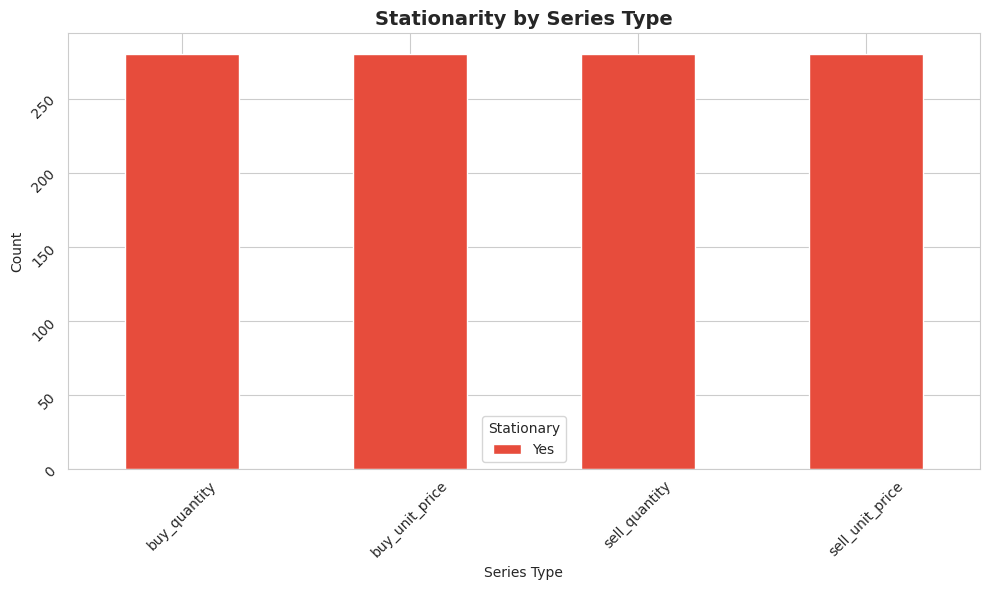

In [16]:
# 4. Stationarity by series type
fig, ax = plt.subplots(figsize=(10, 6))

series_types = adf_df['Series'].str.extract(r'- (.+)$')[0]
stationarity_by_type = pd.crosstab(series_types, adf_df['Stationary (5%)'])
stationarity_by_type.plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'], stacked=False)
ax.set_title('Stationarity by Series Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Series Type')
ax.set_ylabel('Count')
ax.tick_params(rotation=45)
ax.legend(title='Stationary')

plt.tight_layout()
plt.savefig(os.path.join(workdir_modified,"adf_results", 'adf_stationarity_by_type.png'), dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Summary Statistics
print("=" * 80)
print("ADF TEST SUMMARY STATISTICS")
print("=" * 80)
print(f"\nTotal series tested: {len(adf_df)}")
print(f"Stationary series (5% level): {(adf_df['Stationary (5%)'] == 'Yes').sum()} ({(adf_df['Stationary (5%)'] == 'Yes').sum() / len(adf_df) * 100:.2f}%)")
print(f"Non-stationary series (5% level): {(adf_df['Stationary (5%)'] == 'No').sum()} ({(adf_df['Stationary (5%)'] == 'No').sum() / len(adf_df) * 100:.2f}%)")

print("\n" + "-" * 80)
print("P-VALUE STATISTICS")
print("-" * 80)
print(f"Mean p-value: {adf_df['p-value'].mean():.4f}")
print(f"Median p-value: {adf_df['p-value'].median():.4f}")
print(f"Min p-value: {adf_df['p-value'].min():.4f}")
print(f"Max p-value: {adf_df['p-value'].max():.4f}")


ADF TEST SUMMARY STATISTICS

Total series tested: 1120
Stationary series (5% level): 1120 (100.00%)
Non-stationary series (5% level): 0 (0.00%)

--------------------------------------------------------------------------------
P-VALUE STATISTICS
--------------------------------------------------------------------------------
Mean p-value: 0.0000
Median p-value: 0.0000
Min p-value: 0.0000
Max p-value: 0.0000


In [18]:
# Stationarity breakdown by series type
series_types = adf_df['Series'].str.extract(r'- (.+)$')[0]

print("-" * 80)
print("STATIONARITY BY SERIES TYPE")
print("-" * 80)
series_types_summary = pd.crosstab(series_types, adf_df['Stationary (5%)'], margins=True)
print(series_types_summary)

--------------------------------------------------------------------------------
STATIONARITY BY SERIES TYPE
--------------------------------------------------------------------------------
Stationary (5%)   Yes   All
0                          
buy_quantity      280   280
buy_unit_price    280   280
sell_quantity     280   280
sell_unit_price   280   280
All              1120  1120


In [19]:
# Top and bottom series
print("-" * 80)
print("TOP 10 MOST STATIONARY SERIES (lowest p-values)")
print("-" * 80)
print(adf_df.nsmallest(10, 'p-value')[['Series', 'ADF Statistic', 'p-value', 'Stationary (5%)']].to_string(index=False))

print("\n" + "-" * 80)
print("TOP 10 LEAST STATIONARY SERIES (highest p-values)")
print("-" * 80)
print(adf_df.nlargest(10, 'p-value')[['Series', 'ADF Statistic', 'p-value', 'Stationary (5%)']].to_string(index=False))

--------------------------------------------------------------------------------
TOP 10 MOST STATIONARY SERIES (lowest p-values)
--------------------------------------------------------------------------------
                       Series  ADF Statistic  p-value Stationary (5%)
    Item 19703 - buy_quantity     -22.262482      0.0             Yes
  Item 19703 - buy_unit_price     -32.618008      0.0             Yes
   Item 19703 - sell_quantity     -21.699888      0.0             Yes
 Item 19703 - sell_unit_price     -32.848812      0.0             Yes
   Item 102255 - buy_quantity    -174.276359      0.0             Yes
 Item 102255 - buy_unit_price     -30.658591      0.0             Yes
  Item 102255 - sell_quantity     -32.744961      0.0             Yes
Item 102255 - sell_unit_price     -35.641435      0.0             Yes
    Item 75270 - buy_quantity    -175.337921      0.0             Yes
  Item 75270 - buy_unit_price    -175.806809      0.0             Yes

-------------------

In [20]:
import os

# Save to CSV
output_path = os.path.join(workdir_modified,"adf_results", 'adf_test_results.csv')
adf_df.to_csv(output_path, index=False)
print(f"ADF test results saved to: {output_path}")

# Optional: Save a summary report
summary_path = os.path.join(workdir_modified,"adf_results", 'adf_summary.txt')
series_types = adf_df['Series'].str.extract(r'- (.+)$')[0]

with open(summary_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("ADF TEST SUMMARY REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Total series tested: {len(adf_df)}\n")
    f.write(
        f"Stationary series (5% level): {(adf_df['Stationary (5%)'] == 'Yes').sum()} ({(adf_df['Stationary (5%)'] == 'Yes').sum() / len(adf_df) * 100:.2f}%)\n")
    f.write(
        f"Non-stationary series (5% level): {(adf_df['Stationary (5%)'] == 'No').sum()} ({(adf_df['Stationary (5%)'] == 'No').sum() / len(adf_df) * 100:.2f}%)\n\n")

    f.write("-" * 80 + "\n")
    f.write("P-VALUE STATISTICS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Mean p-value: {adf_df['p-value'].mean():.4f}\n")
    f.write(f"Median p-value: {adf_df['p-value'].median():.4f}\n")
    f.write(f"Min p-value: {adf_df['p-value'].min():.4f}\n")
    f.write(f"Max p-value: {adf_df['p-value'].max():.4f}\n\n")

    f.write("-" * 80 + "\n")
    f.write("STATIONARITY BY SERIES TYPE\n")
    f.write("-" * 80 + "\n")
    series_types_summary = pd.crosstab(series_types, adf_df['Stationary (5%)'], margins=True)
    f.write(series_types_summary.to_string())
    f.write("\n")

print(f"Summary report saved to: {summary_path}")

ADF test results saved to: /models/data/workdir_lusis/modified/adf_test_results.csv
Summary report saved to: /models/data/workdir_lusis/modified/adf_summary.txt
